In [1]:
import tensorflow as tf
import keras
from keras.layers import Rescaling
from keras.preprocessing import image
from keras.applications import MobileNetV2
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

In [2]:
# Define paths
dataset_path = './Data/CNN_datasets/new'
train_data_path = './Data/CNN_datasets/faster-RCNN/train_data'
test_data_path = './Data/CNN_datasets/faster-RCNN/test_data'

# Split data into training and testing
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    images = os.listdir(class_path)
    train_images, test_images = train_test_split(images, test_size=0.25, random_state=42)

    # Create folders for training and testing
    os.makedirs(os.path.join(train_data_path, class_folder), exist_ok=True)
    os.makedirs(os.path.join(test_data_path, class_folder), exist_ok=True)

    # Move images to respective folders
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_data_path, class_folder, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_data_path, class_folder, img))

In [5]:
# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Add rotation
    width_shift_range=0.2,  # Add horizontal shift
    height_shift_range=0.2,  # Add vertical shift
    brightness_range=[0.8, 1.2],  # Adjust brightness
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),  # Adjust to desired size
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 1124 images belonging to 4 classes.
Found 380 images belonging to 4 classes.


In [15]:
# Load pre-trained ResNet50 model without top layers
base_model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Add Rescaling layer before base model
rescale_layer = Rescaling(1./255)  # Normalize to [0, 1]
inp = rescale_layer(base_model.input)
x = base_model(inp)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for object detection
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),  # Adjust learning rate as needed
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [16]:
# Train the model
history= model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/20
35/35 [==============================] - 40s 1s/step - loss: 1.3644 - accuracy: 0.5696 - val_loss: 1.3295 - val_accuracy: 0.8239
Epoch 2/20
35/35 [==============================] - 39s 1s/step - loss: 1.3156 - accuracy: 0.7839 - val_loss: 1.2694 - val_accuracy: 0.8381
Epoch 3/20
35/35 [==============================] - 37s 1s/step - loss: 1.2670 - accuracy: 0.8040 - val_loss: 1.2129 - val_accuracy: 0.8466
Epoch 4/20
35/35 [==============================] - 37s 1s/step - loss: 1.2172 - accuracy: 0.8196 - val_loss: 1.1533 - val_accuracy: 0.8438
Epoch 5/20
35/35 [==============================] - 37s 1s/step - loss: 1.1649 - accuracy: 0.7976 - val_loss: 1.0899 - val_accuracy: 0.8381
Epoch 6/20
35/35 [==============================] - 37s 1s/step - loss: 1.1095 - accuracy: 0.7985 - val_loss: 1.0197 - val_accuracy: 0.8381
Epoch 7/20
35/35 [==============================] - 37s 1s/step - loss: 1.0557 - accuracy: 0.7912 - val_loss: 0.9567 - val_accuracy: 0.8494
Epoch 8/20
35/35 [==

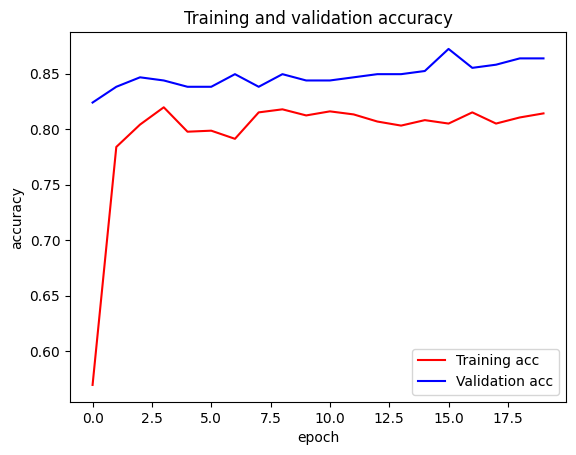

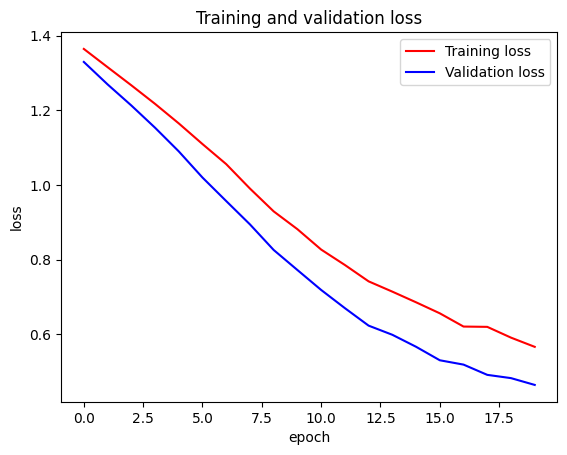

In [17]:
# Training and validation graphing
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [18]:
# Save the model
model.save('faster-RCNN_modelv3.h5')

C:\Users\ASUS TUF X506H\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Load model
model = load_model('faster-RCNN_modelv3.h5')

# Load and preprocess the image
image_path = './Data/CNN_datasets/final_testing/1.jpeg'
img = image.load_img(image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Generate predictions on the image
predictions = model.predict(img_array)

# Process predictions
# Assuming the model predicts bounding box coordinates and class probabilities
# You can modify this code based on the output format of your model
# Extract the class labels and bounding box coordinates
class_labels = ['buffalo', 'elephant', 'zebra','rhino']  # Replace with your actual class labels
predicted_labels = [class_labels[i] for i in np.argmax(predictions, axis=1)]

bounding_boxes = predictions[:, :4]  # Assuming the bounding box coordinates are the first 4 values in each prediction

# Visualize the image and predictions
plt.imshow(img)
plt.title('Image Prediction')

# Draw bounding boxes and labels on the image
for label, bbox in zip(predicted_labels, bounding_boxes):
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x, y, label, color='red', fontsize=12)

plt.show()


ValueError: in user code:

    File "C:\Users\ASUS TUF X506H\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\ASUS TUF X506H\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ASUS TUF X506H\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\ASUS TUF X506H\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\ASUS TUF X506H\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ASUS TUF X506H\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256, 3)


In [19]:
# Load model
model = load_model('faster-RCNN_modelv3.h5')

# Generate predictions on the validation set
predictions = model.predict(validation_generator)

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(validation_generator.classes, predictions.argmax(axis=1))
precision = precision_score(validation_generator.classes, predictions.argmax(axis=1), average='weighted')
recall = recall_score(validation_generator.classes, predictions.argmax(axis=1), average='weighted')
f1 = f1_score(validation_generator.classes, predictions.argmax(axis=1), average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

# Visualize results (optional)
# You can use visualization tools like Matplotlib or OpenCV to visualize bounding boxes and predictions


12/12 [==============================] - 9s 635ms/step
Accuracy: 0.25
Precision: 0.24753638162186287
Recall: 0.25
F1-score: 0.24576260857193463
